<span style="font-size:42px; "><strong>Thickness calculation from laser signal </strong></span>

<hr>

This notebook is for fitting a sinusoidal function to data for the measurement of the laser signal against time.


# Imports

In [14]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
#%matplotlib qt

# File handling and data inspection

The laser signal data should be saves as a .csv file containing two columns of comma-separated values

column 1 = time (s)

column 2 = laser signal (mV)

If there are any headers, these can be ignored by changing the value in 'skiprows=0'

Since the file structure is very simple we can use numpy to read from the file - we don't need Pandas dataframes. We will also use numpy to carry out the necessary mathematical functions on the data (e.g. apply a multiplier to scale the data or offset the data vertically to correct for a non-zero baseline).

To inspect the data, plots will be generated using matplotlib.

The fitting is carried out using curve_fit from the scipy.optimize package.

First load the data file by entering the filename below:


In [31]:
date = "2020_09_15"
spl = "ASW"
XP = "XP_1-1"
#T_Dep = ""


#filename="..\..\Data\DATA_RAW\{}\laser-diode_{}-.csv".format(date,date)

## Import

Need to extract x (time/s) and y (Voltage/mV)

In [32]:
data_thick = pd.read_excel("..\..\Data\DATA_RAW\{}\laser-diode_{}.xlsx".format(date,date), header=1)

In [33]:
data_thick

,time/min,time/s,voltage/mV,baratron,p(chamber),Unnamed: 5
0,NaN,0,325,NaN,2.50,e-9
1,NaN,30,324,NaN,1.08,e-7
2,1.0,60,324,NaN,NaN,NaN
3,NaN,90,323,NaN,NaN,NaN
4,2.0,120,323,NaN,NaN,NaN
5,NaN,150,322,NaN,1.11,NaN
6,3.0,180,322,NaN,NaN,NaN
7,NaN,210,322,NaN,NaN,NaN
8,4.0,240,323,NaN,NaN,NaN
9,NaN,270,323,NaN,1.12,NaN


### Split df into the column of interests

In [34]:
data_thick_sel = data_thick[["time/s", "voltage/mV"]]

In [35]:
data_thick_sel.head(60)

,time/s,voltage/mV
0,0,325
1,30,324
2,60,324
3,90,323
4,120,323
5,150,322
6,180,322
7,210,322
8,240,323
9,270,323


### Nans value ?

In [36]:
data_thick_clean = data_thick_sel.dropna()

In [37]:
data_thick_clean.head(60)

,time/s,voltage/mV
0,0,325
1,30,324
2,60,324
3,90,323
4,120,323
5,150,322
6,180,322
7,210,322
8,240,323
9,270,323


In [38]:
def create_lists_from_df_columns(df1, df2, col1, col2):
    x = df1[col1].tolist()
    y = df2[col2].tolist()
    return list1, list2


In [39]:
df1 = pd.DataFrame({'col1': data_thick_clean["time/s"]})
df2 = pd.DataFrame({'col2': data_thick_clean["voltage/mV"]})
x, y = create_lists_from_df_columns(df1, df2, 'col1', 'col2')

### Sanity check

In [42]:
#y

#y

In some cases the signal may appear negative deepenting on the polarity of the connections to the laser diode. A simple way to fix this is with the following code

In [43]:
#checks for negative signal and makes it positive
if np.any(y < 0):
    y = -1*y

TypeError: '<' not supported between instances of 'list' and 'int'

# 2 Fitting

The sinusoidal signal takes the form
$$y = y_0 + A sin(\frac{2\pi}{w}(x-x_c))$$

where $y_0$ is the vertical offset, $A$ is the amplitude, $x_c$ is the horizontal offset and $w$ is the period (i.e. $2\pi/w$ is the frequency)

We define the sine function 'sinfit(x, *p)' for the fit with some initial guesses, which can be edited accordingly.



## Function

In [44]:
#sin function used y0 + A*sin(2pi(x-xc)/w)
#with y0=y-offset, A=amplitude, xc=x-offset/phase, w=period 
def sinfit(x,*p):
    y0, A, xc, w = p
    return A*np.sin(2*np.pi*(x-xc)/w)+y0


## Guess 1

In [45]:

#Guess values

guess =[330, 4, 0, 400]
popt =[324, 4, 0, 400]


#fits the funtion and returns the parameters of the fit poppt[as many guesses as you have]
popt, pcov = curve_fit(sinfit, x, y, p0=guess, maxfev=10000, absolute_sigma=True)

#chi squared calculation
chi_squared = np.sum(((y-sinfit(x,*popt))**2)/(sinfit(x,*popt)) )
perr = np.sqrt(np.diag(pcov))

## Plot 1

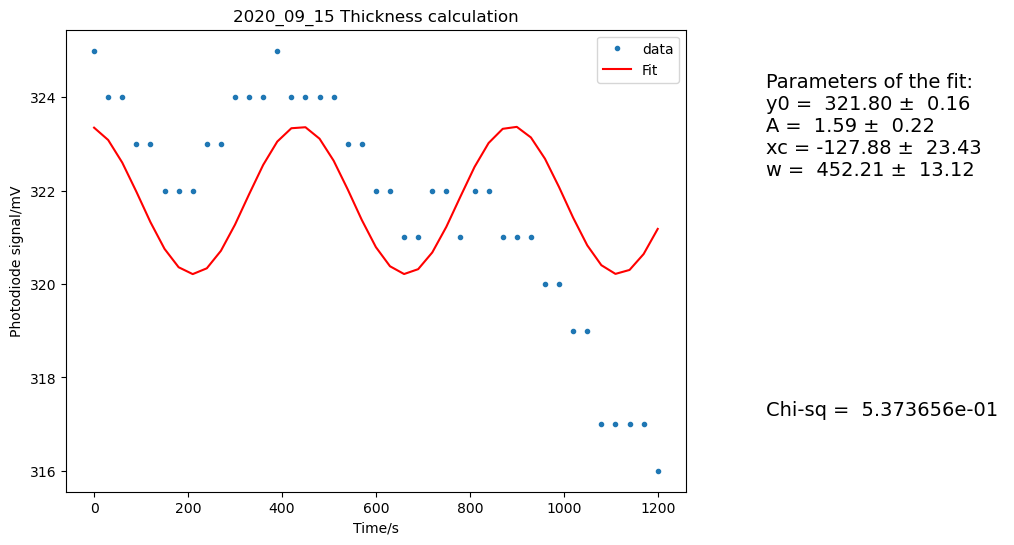

Chi-sq =  5.373656e-01 

Parameters of the fit:
y0 =  321.80 ±  0.16
A =  1.59 ±  0.22
xc = -127.88 ±  23.43
w =  452.21 ±  13.12



In [47]:
fig= plt.figure(figsize=(8,6))


t1 = str(f"Chi-sq = {chi_squared: 2e} \n")

t2 = str(f"Parameters of the fit:\n\
y0 = {popt[0]: .2f} \u00B1 {perr[0]: .2f}\n\
A = {popt[1]: .2f} \u00B1 {perr[1]: .2f}\n\
xc = {popt[2]: .2f} \u00B1 {perr[2]: .2f}\n\
w = {popt[3]: .2f} \u00B1 {perr[3]: .2f}\n")

#plots:
plt.plot(x, y, '.', label='data' )
plt.plot(x, sinfit(x,*popt),'r-', label='Fit')
plt.title('{0} Thickness calculation'.format(date))
plt.xlabel('Time/s')
plt.ylabel(r'Photodiode signal/mV')
plt.legend()
plt.text(1, 0.2, t1, fontsize=14, transform=plt.gcf().transFigure)
plt.text(1, 0.6, t2, fontsize=14, transform=plt.gcf().transFigure)

#plt.savefig('D:\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/Thickness-calc_{}_1.png'.format(XP, date, date), bbox_inches="tight")


plt.show()

#print calculated chi suqared
t1 = print(f"Chi-sq = {chi_squared: 2e} \n")

#print parameters of the fit
t2 = print(f"Parameters of the fit:\n\
y0 = {popt[0]: .2f} \u00B1 {perr[0]: .2f}\n\
A = {popt[1]: .2f} \u00B1 {perr[1]: .2f}\n\
xc = {popt[2]: .2f} \u00B1 {perr[2]: .2f}\n\
w = {popt[3]: .2f} \u00B1 {perr[3]: .2f}\n")







### Guess 2

In [375]:
#normal values

guess =[330, 4, 0, 400]
popt =[324, 4, 0, 400]

#17-09 values

#guess =[323, 4, 25, 50]
#popt =[324, 2.4, 25, 25]

#21_09

#guess =[325, 4, 2000, 4000]
#popt =[324, 2.4, 2000, 4000]

x2 = x[(x>0) & (x<1200)]
y2 = y[(x>0) & (x<1200)]

#x2 = x[(x>0) & (x<3800)  + (x>4500) & (x<8000)]
#y2 = y[(x>0) & (x<3800) + (x>4500) & (x<8000)] 






#fits the funtion and returns the parameters of the fit poppt[as many guesses as you have]
popt, pcov = curve_fit(sinfit, x2, y2, p0=guess, maxfev=10000, absolute_sigma=True)

#chi squared calculation
chi_squared = np.sum(((y-sinfit(x,*popt))**2)/(sinfit(x,*popt)) )
perr = np.sqrt(np.diag(pcov))

## Plot 2

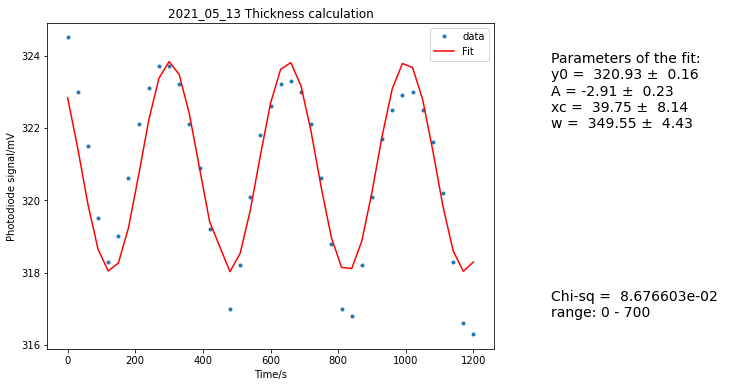

Chi-sq =  8.676603e-02 

Parameters of the fit:
y0 =  320.93 ±  0.16
A = -2.91 ±  0.23
xc =  39.75 ±  8.14
w =  349.55 ±  4.43



In [376]:
fig= plt.figure(figsize=(8,6))


t1 = str(f"Chi-sq = {chi_squared: 2e}  \n\
range: 0 - 700")




t2 = str(f"Parameters of the fit:\n\
y0 = {popt[0]: .2f} \u00B1 {perr[0]: .2f}\n\
A = {popt[1]: .2f} \u00B1 {perr[1]: .2f}\n\
xc = {popt[2]: .2f} \u00B1 {perr[2]: .2f}\n\
w = {popt[3]: .2f} \u00B1 {perr[3]: .2f}\n")

#plots:
plt.plot(x, y, '.', label='data' )
plt.plot(x, sinfit(x,*popt),'r-', label='Fit')
plt.title('{0} Thickness calculation'.format(date))
plt.xlabel('Time/s')
plt.ylabel(r'Photodiode signal/mV')
plt.legend()
plt.text(1, 0.2, t1, fontsize=14, transform=plt.gcf().transFigure)
plt.text(1, 0.6, t2, fontsize=14, transform=plt.gcf().transFigure)

#plt.savefig('D:\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/Thickness-calc_{}_2.png'.format(XP, date, date), bbox_inches="tight")


plt.show()

#print calculated chi suqared
t1 = print(f"Chi-sq = {chi_squared: 2e} \n")

#print parameters of the fit
t2 = print(f"Parameters of the fit:\n\
y0 = {popt[0]: .2f} \u00B1 {perr[0]: .2f}\n\
A = {popt[1]: .2f} \u00B1 {perr[1]: .2f}\n\
xc = {popt[2]: .2f} \u00B1 {perr[2]: .2f}\n\
w = {popt[3]: .2f} \u00B1 {perr[3]: .2f}\n")



# 3 Thickness Calculation

To calculate the film thickness we use the thin film interference equation:

$$d = \frac{\lambda_0}{2n_1 cos\theta_1}$$

where $\lambda_0$ is the wavelength of the laser in vacuum (632.8 nm), $n_1$ is the refractive index of the film and $\theta_1$ is the angle of reflection within the film (at the substrate/ice interface).

The refractive index of the film $n$ is estimated fromthe ratio of the maxima and the minima of the sinusoidal fit:

$$n = \frac{y_0 + A}{y_0 - A}$$

To obtain  $\theta_1$ we use Snell's law

$$n_1 sin\theta_1 = n_0 sin\theta_0$$

where $n_0 = 1$ in vacuum and $\theta_0$ is 20$^\circ$



In [377]:
#refractive index is given by n = (y0+A)/(y0-A)
n1=(popt[0]+popt[1])/(popt[0]-popt[1])

print (f"Refractive index of ice film, n1 = {n1: .2f} at 632.8 nm")

#n1*sin(theta1)=n0*sin(theta0), so theta1=arcsin(sin(20deg)/n1)
#!Attention, python numpy works in radians
theta0=np.radians(20)

theta1=np.arcsin(np.sin(theta0)/n1)
theta1_deg=np.rad2deg(theta1)

print (f"\ntheta1 = {theta1_deg: .2f} degrees")

#thickness per fringe, d = lambda(632.8)/2*n1*cos(theta1)
d=632.8/(2*n1*np.cos(theta1))

print (f"\nd = {d:.2f} nm per fringe")


Refractive index of ice film, n1 =  0.98 at 632.8 nm

theta1 =  20.38 degrees

d = 343.71 nm per fringe


Finally, to calculate the thickness:
$d$ gives the thickness per fringe and the period $w$ gives the time per fringe, so the rate given by thickness/time is (thickness/fringe)/(time/fringe) = $d/w$. 

In [378]:
#rate = (thickness/fringe) / (time/fringe)
rate=d/popt[3]

print (f"Deposition rate = {rate: .2f} nm/s")


Deposition rate =  0.98 nm/s


$\color{red}{\text{How to convert in ML/s}}$

To obtain the final thickness, multiply the rate (nm/s) by the total deposition time (s)

In [379]:
#enter deposition time, t in seconds
t= float(1200)

#calculate thickness, l in nm
thickness=rate*t

print (f"Ice film thickness, l = {thickness: .2f} nm")

Ice film thickness, l =  1179.95 nm


# 4 Data Export

In [380]:
Ice_thick_date = []

In [381]:
Ice_thick_date.append(
        
        {
            'Sample' : str(spl),
            'Date' : str(date),
            'n1' :  n1,
            'teta1' : theta1_deg,
            'd' : d,
            'rate' : rate,
            'thickness' : thickness,
            'Na' : "",
            'Nc' : "", 

            })

In [382]:
Ice_thick_date_df = pd.DataFrame(Ice_thick_date)

In [383]:
Ice_thick_date_df

,Sample,Date,n1,teta1,d,rate,thickness,Na,Nc
0,ASW,2021_05_13,0.982035,20.381966,343.707107,0.983288,1179.945506,,


In [384]:
Ice_thick_df = pd.read_csv('D:\DATA-Processing\PAC\Ice_thickness.csv')

In [385]:
XP_Date = []

XP_Date = str(Ice_thick_df['Date'])
print(XP_Date)

0    2020_09_15
1    2020_09_16
2    2020_09_17
3    2020_09_21
4    2020_09_28
5    2020_10_22
6    2020_11_16
7    2020_11_19
Name: Date, dtype: object


In [386]:
#if date in XP_Date:
    #    print("Not appended")
#else:
Ice_thick_date_df.to_csv('D:\DATA-Processing\PAC\Ice_thickness.csv', mode='a', header=False, index=False)

## Data Visualisation

In [387]:
Ice_thick_df

,Sample,Date,n1,teta1,d,rate,thickness,Na,Nc
0,ASW,2020_09_15,0.993048,20.146063,339.379075,0.755029,906.035346,4.810000e+17,5.590000e+17
1,ASW,2020_09_16,0.986981,20.275327,341.749008,0.896849,1076.218697,4.795654e+17,5.793533e+17
2,ASW,2020_09_17,1.013398,19.724534,331.677757,6.971830,836.619653,6.757415e+17,4.839162e+17
3,ASW,2020_09_21,1.012572,19.741297,331.983246,0.065403,784.835867,4.434018e+17,4.418921e+17
4,ASW,2020_09_28,1.011625,19.760549,332.334152,0.755904,907.084289,4.327905e+17,5.492510e+17
5,ASW,2020_10_22,1.185651,16.766143,278.705278,0.569413,683.295683,4.814449e+17,3.791857e+17
6,ASW,2020_11_16,0.969877,20.649048,348.623208,1.197077,1436.492762,4.843517e+17,4.927852e+17
7,ASW,2020_11_19,1.032910,19.336941,324.632254,1.064639,1341.444856,5.072321e+17,6.167617e+17


# Export Result in web-page

In [388]:
f = open("D:\DATA-Processing\PAC\{}/Samples/{}/{}_DP.html".format(XP,date,date),'a')



message = """<html>
<head></head>
<body>



<h1>Sample thickness </h1>

<figure>
<a href="Plots\DR\Thickness-calc_"""+str(date) + """_2.png" target="_blank"><image src="Plots\DR\Thickness-calc_"""+str(date) + """_2.png" width=""  Id=""  alt=""/></a>      
<figcaption></figcaption>
</figure>

<p>Output</p>





</body>
</html>"""




f.write(message)
f.close()